In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)    #set figure size for the notebook

Option 1: <b> geotiler </b><br>

http://wrobell.it-zone.org/geotiler/intro.html

In [2]:
import geotiler

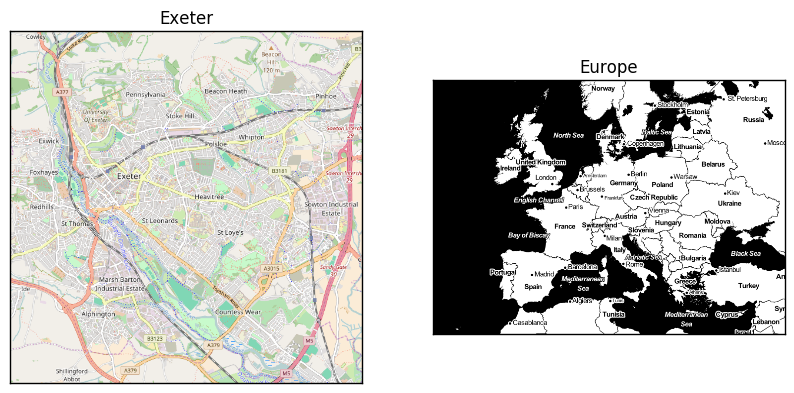

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)   #initialize 2 subplots within the figure

#load map first subplot: Exeter
m1 = geotiler.Map(center=(-3.51,50.72), zoom=13, size=(600,600))          # size affects the map geographical extend
m1.provider = geotiler.find_provider('osm')
image1 = geotiler.render_map(m1)
ax1.set_xticks([])                  #remove axis tick labels
ax1.set_yticks([])
ax1.set_title("Exeter")
ax1.imshow(image1)

# 2nd map: Europe
m2 = geotiler.Map(center=(10,49), zoom=4, size=(712,512))
m2.provider = geotiler.find_provider('stamen-toner')
image2 = geotiler.render_map(m2)
ax2.set_xticks([]) 
ax2.set_yticks([])
ax2.set_title("Europe")
ax2.imshow(image2)

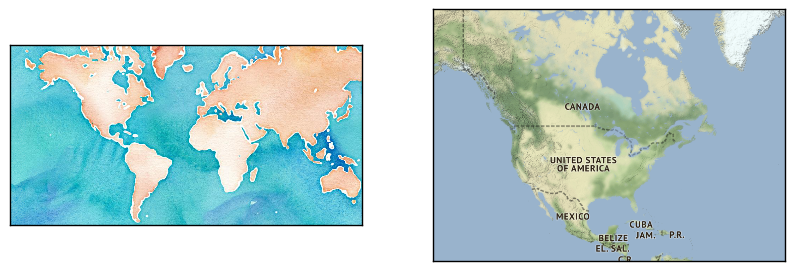

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2)   #initialize 2 subplots within the figure

m1 = geotiler.Map(center=(-20,20), zoom=2, size=(1000,512))          # size affect the map geographical extend (first number is longitude)
m1.provider = geotiler.find_provider('stamen-watercolor')
image1 = geotiler.render_map(m1)
ax1.set_xticks([]) 
ax1.set_yticks([]) 
ax1.imshow(image1)

m2 = geotiler.Map(center=(-90,47), zoom=3, size=(700,500))
m2.provider = geotiler.find_provider('stamen-terrain')
image2 = geotiler.render_map(m2)
ax2.set_xticks([]) 
ax2.set_yticks([]) 
ax2.imshow(image2)

All matplotlib functionality can be plotted on top of these tiles <br>
<br>
We will use a kaggle dataset as example:<br>
https://www.kaggle.com/nhtsa/2015-traffic-fatalities<br>
And plot accident locations on top of the geotiler map

In [5]:
import pandas as pd
df = pd.read_csv("traffic_fatalities/accident.csv")
df = df[(df["LONGITUD"]!=999.9999) & (df["MINUTE"]!=99)]     #removing missing data
df = df[["STATE","PERSONS","DAY","MONTH","YEAR","DAY_WEEK","HOUR","MINUTE","LATITUDE","LONGITUD","FATALS"]]
df.head(3)
#PERSONS=nbr of ppl involved in crash and FATALS=nbr of deads

,STATE,PERSONS,DAY,MONTH,YEAR,DAY_WEEK,HOUR,MINUTE,LATITUDE,LONGITUD,FATALS
0,1,1,1,1,2015,5,2,40,33.878653,-87.325328,1
1,1,1,1,1,2015,5,22,13,34.910442,-86.908708,1
2,1,2,1,1,2015,5,1,25,32.142006,-85.758456,1


First let's look at accidents for the month of january, the larger dot indicates higher casualty number (removing HAWAI and ALASKA)

In [6]:
jan = df[(df["MONTH"]==1) & (df["STATE"]!=2) & (df["STATE"]!=15)][["YEAR","DAY","MONTH","HOUR","MINUTE","LONGITUD","LATITUDE","FATALS"]]

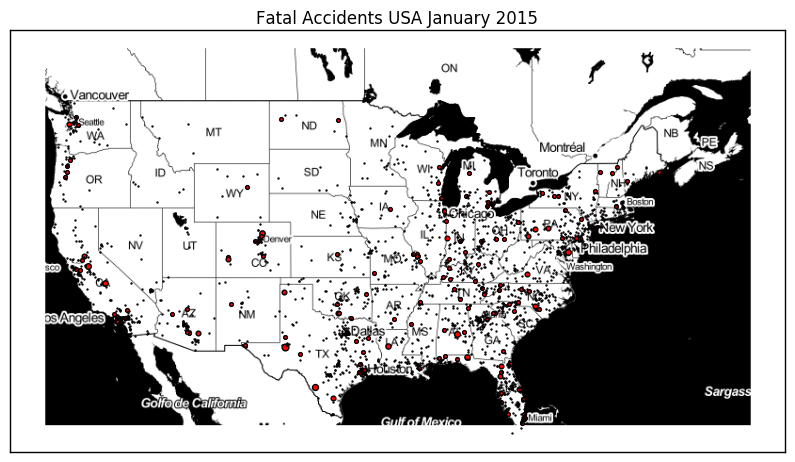

In [7]:
ax = plt.subplot(111)
m = geotiler.Map(center=(-92,40), zoom=4, size=(750,400))
m.provider = geotiler.find_provider('stamen-toner')
image = geotiler.render_map(m)
ax.set_xticks([]) 
ax.set_yticks([])
ax.set_title("Fatal Accidents USA January 2015")
ax.imshow(image)

for i in range(len(jan)):
    accident_coordinates = (jan['LONGITUD'].iloc[i],jan['LATITUDE'].iloc[i])
    x, y = m.rev_geocode(accident_coordinates)            #rev_geocode to position the coordinates on the geotiler map
    ax.scatter(x, y, c='red',s=(0.5+10*np.log(jan['FATALS'].iloc[i])))

Now lets create an animation of the timeline of accidents <br>

In [8]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation  #to animate within the notebook
from JSAnimation import HTMLWriter                         #to embedd in html

In [9]:
#sort the df by accident timestamp, and create 4 vectors holding the latitude, longitude, fatality number
from datetime import datetime
date_objects = [datetime.strptime(str(jan["YEAR"].iloc[i])+'-'+str(jan["MONTH"].iloc[i])+'-'+str(jan["DAY"].iloc[i])+' '+str(jan["HOUR"].iloc[i])+':'+str(jan["MINUTE"].iloc[i]),'%Y-%m-%d %H:%M') for i in range(len(jan))]
jan["TIMESTAMP"]=date_objects
jan = jan.sort_values("TIMESTAMP")
times = list([str(x) for x in jan["TIMESTAMP"]])
lat = list(jan["LATITUDE"])
lon = list(jan["LONGITUD"])
fatalities = list(jan["FATALS"])
casualties = [str(sum(jan["FATALS"].iloc[:i]))+ ' dead' for i in range(len(jan))]

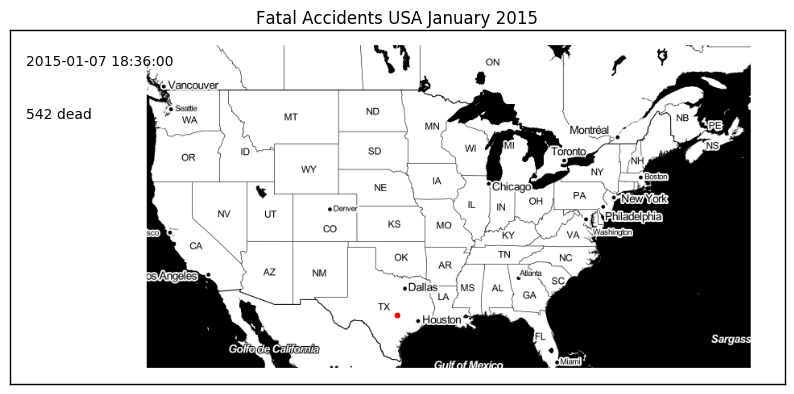

In [11]:
#Setting up the figure
fig, ax = plt.subplots()
m = geotiler.Map(center=(-92,40), zoom=4, size=(750,400))
m.provider = geotiler.find_provider('stamen-toner')
image = geotiler.render_map(m)
ax.set_xticks([]) 
ax.set_yticks([])
ax.set_title("Fatal Accidents USA January 2015")
ax.imshow(image)
colors = ["red" for x in range(len(fatalities))]
dot = ax.scatter(lon,lat,c=colors,s=10)
text1 = ax.text(0.02, 0.90, '', transform=ax.transAxes)
text2 = ax.text(0.02,0.75, '', transform=ax.transAxes)

# initialization function: plot the background of each frame
def init():
    dot.set_data([], [])
    return (dot,)

# animation function. This is called sequentially
def animate(i):
    x, y = m.rev_geocode((lon[i],lat[i]))
    dot.set_offsets((x,y))
    dot.set_color("red")
    text1.set_text(times[i])
    text2.set_text(casualties[i])
    return (dot,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=500, interval=10, blit=True)

#display_animation(anim)
# set embed_frames=True to embed base64-encoded frames directly in the HTML
anim.save('animation.html', writer=HTMLWriter(embed_frames=False))